In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.pdhg import pdhg_method_AB, prox_l1, check_dual_feasible, pdhg_diagonal_scaling
from utils_pdhg import *

In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## Diagonally Preconditioned PDHG

In [18]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5

        # Torch tensors
        A = torch.from_numpy(A_np).to(torch.float32).to(device)
        B = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        nA = torch.linalg.norm(A, ord="fro").item()
        nB = torch.linalg.norm(B, ord="fro").item()
        lamb_max = (nA * nA + nB * nB) ** 0.5
        mu_reg = max(1e-4 * lamb_max**2, 1e-4)

        Z0_1, Z0_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z1_t, Z2_t, residuals, _ = pdhg_method_AB(
            prox_h_conj,
            W_k=A,
            W_q=B,
            G_wk=G1,
            G_wq=G2,
            mu=mu_reg,
            max_iter=10000,
            eps_abs=1e-8,
            eps_rel=1e-8,
            stopping=True,
            h_conj=h_conj,
            f_star=f_star,
            diag_scaling=True,
        )

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
        print("PASSED")

lamb_max=60.43757578940953
PASSED
lamb_max=59.59920081813336
PASSED
lamb_max=60.26169446926458
PASSED
lamb_max=59.56162428506695
PASSED
lamb_max=59.20130717635874
PASSED
lamb_max=59.82465595225018
PASSED
lamb_max=60.41357053468525
PASSED
lamb_max=60.33319904310275
PASSED
lamb_max=59.320557609015076
PASSED
lamb_max=61.15709153420114
PASSED


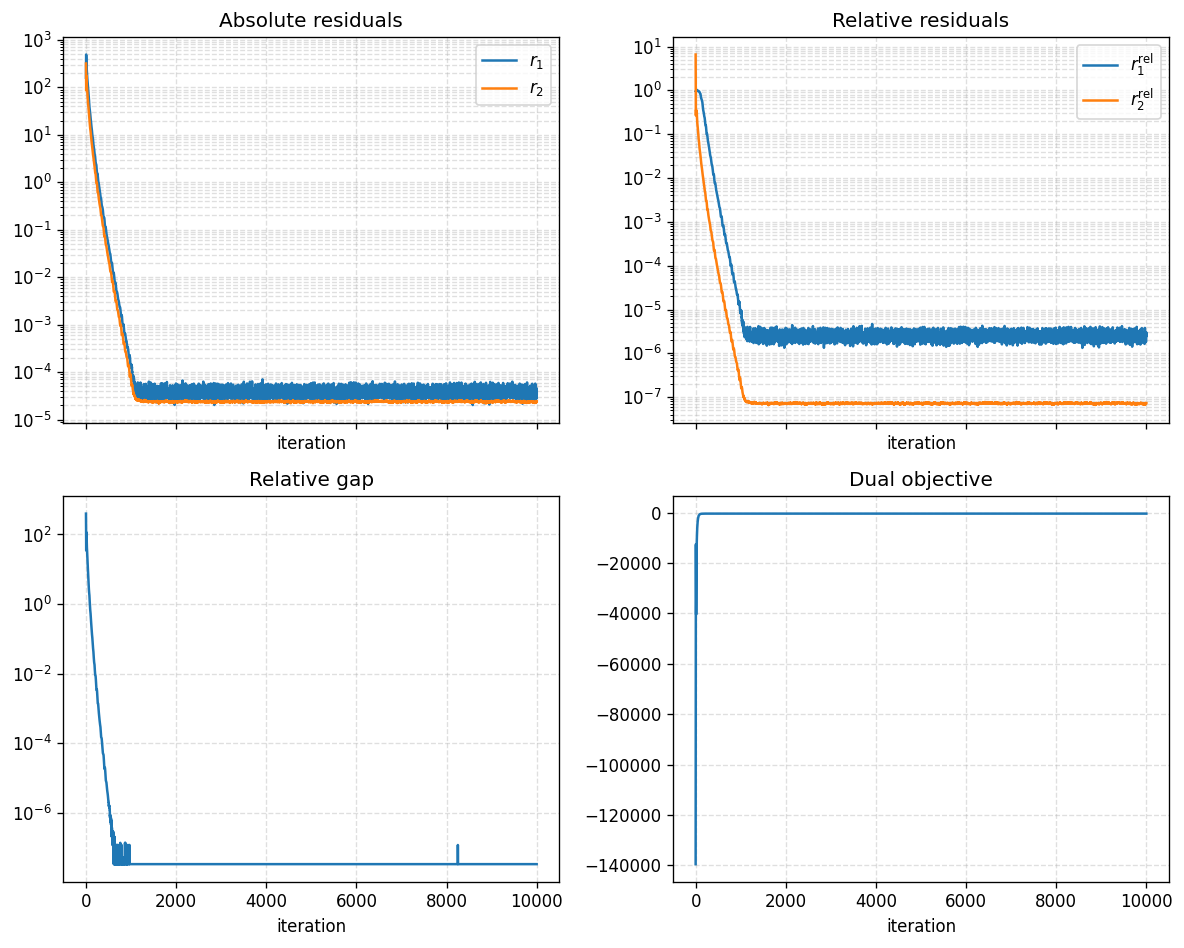

In [19]:
plot_residuals(residuals)

## Accelerated PDHG

In [20]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5

        # Torch tensors
        A = torch.from_numpy(A_np).to(torch.float32).to(device)
        B = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        nA = torch.linalg.norm(A, ord="fro").item()
        nB = torch.linalg.norm(B, ord="fro").item()
        lamb_max = (nA * nA + nB * nB) ** 0.5
        mu_reg = max(1e-4 * lamb_max**2, 1e-4)

        Z0_1, Z0_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z1_t, Z2_t, residuals, _ = pdhg_method_AB(
            prox_h_conj,
            W_k=A,
            W_q=B,
            G_wk=G1,
            G_wq=G2,
            mu=mu_reg,
            max_iter=10000,
            eps_abs=1e-8,
            eps_rel=1e-8,
            stopping=True,
            h_conj=h_conj,
            f_star=f_star,
            acceleration=True,
        )

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
        print("PASSED")

lamb_max=58.83608970491337
PASSED
lamb_max=59.35026234462572
PASSED
lamb_max=60.330924854549835
PASSED
lamb_max=60.048816156271755
PASSED
lamb_max=59.10510998661776
PASSED
lamb_max=59.312448643688285
PASSED
lamb_max=59.601192222265674
PASSED
lamb_max=59.97778457403315
PASSED
lamb_max=60.92542048031005
PASSED
lamb_max=61.32051606272949
PASSED


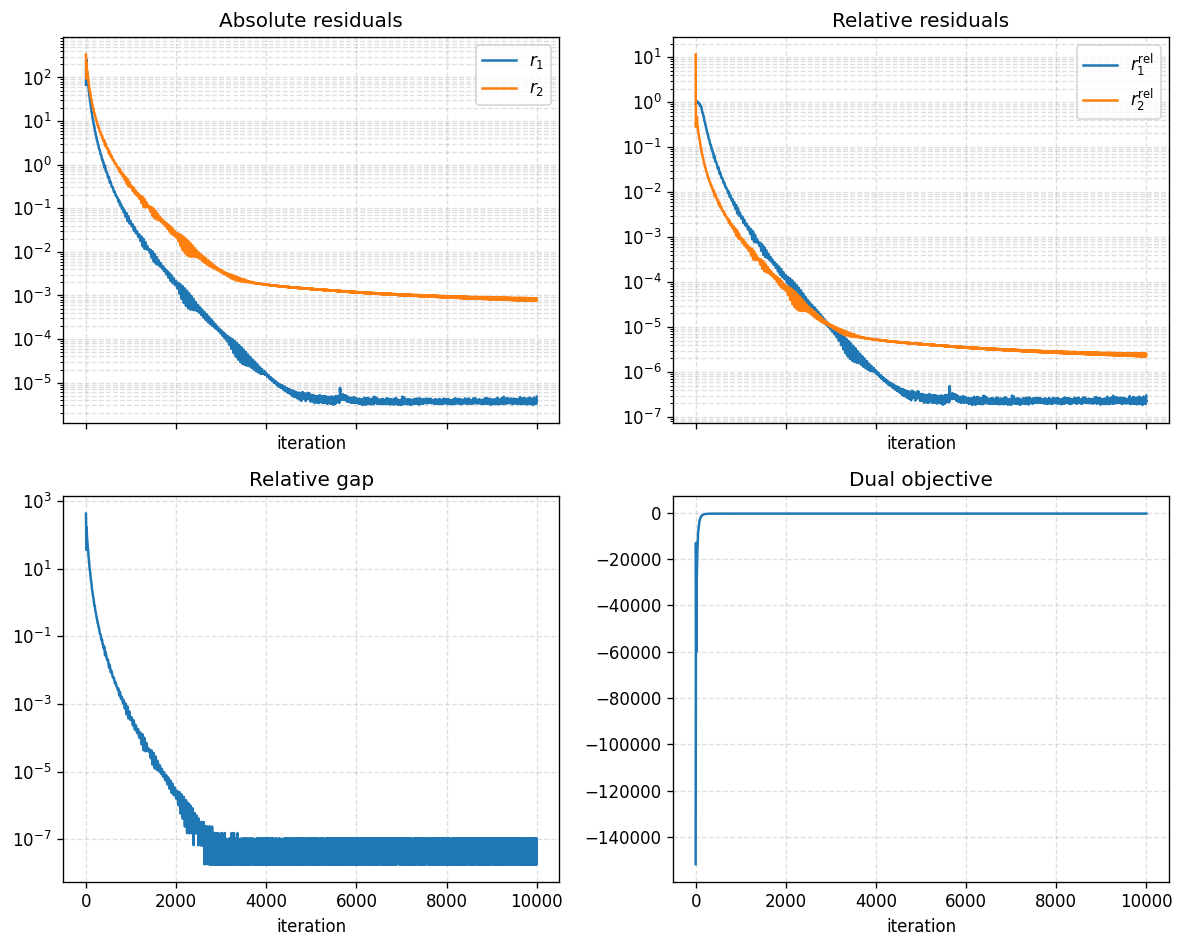

In [21]:
plot_residuals(residuals)

## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$

In [ ]:
for (m, n) in [(20, 40), (40, 20)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 1

        # Torch tensors
        A = torch.from_numpy(A_np).to(torch.float32).to(device)
        B = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        nA = torch.linalg.norm(A, ord="fro").item()
        nB = torch.linalg.norm(B, ord="fro").item()
        lamb_max = (nA * nA + nB * nB) ** 0.5
        mu_reg = max(1e-4 * lamb_max**2, 1e-6)

        Y0, obj0 = cvxpy_ls_l1_reg(A_np, B_np, G1_np, G2_np, beta, mu=mu_reg)

        Y1, residuals = fista_ls_l1_reg(W_k=A, W_q=B, G_wk=G1,
            G_wq=G2, beta=beta, mu=mu_reg, lamb_max=lamb_max, max_iter=10000, eps_abs=1e-8, eps_rel=1e-8)
        assert np.allclose(residuals['dual_vals'][-1], obj0, rtol=1e-4), print(residuals['dual_vals'][-1], obj0)
        
        # primal recovery
        Z1 = (1 / mu_reg) * (- G1 - B @ Y1.T).cpu().numpy()
        Z2 = (1 / mu_reg) * (- G2 - A @ Y1).cpu().numpy()

        Z0_1, Z0_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg)
        
        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-1 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)) <= beta + 1e-1

        # primal recovery via true dual variable
        Z0_1 = (1 / mu_reg) * (- G1_np - B_np @ Y0.T)
        Z0_2 = (1 / mu_reg) * (- G2_np - A_np @ Y0)

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-1 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)) <= beta + 1e-1
        
        print("PASSED")

Fista converged in 3280 iterations.
PASSED
Fista converged in 3012 iterations.
PASSED
Fista converged in 3018 iterations.
PASSED
Fista converged in 3117 iterations.
PASSED
Fista converged in 3007 iterations.
PASSED
Fista converged in 789 iterations.
PASSED
Fista converged in 704 iterations.
PASSED
Fista converged in 799 iterations.
PASSED
Fista converged in 681 iterations.
PASSED
Fista converged in 794 iterations.
PASSED


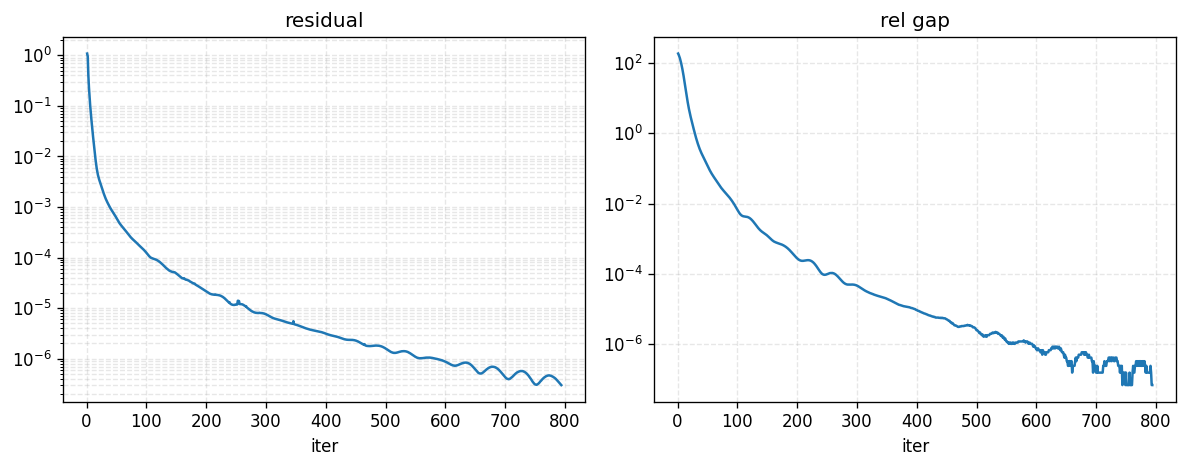

In [ ]:
def plot_residuals_and_gap(logging, obj0):
    r = np.array(logging["r_norm"])
    loss = np.array(logging["loss"])
    gap = np.abs(loss - obj0) / max(1.0, abs(obj0))
    it = np.arange(1, len(r) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
    ax[0].plot(it, r);    ax[0].set_yscale("log"); ax[0].set_title("residual"); ax[0].set_xlabel("iter")
    ax[1].plot(it, gap);  ax[1].set_yscale("log"); ax[1].set_title("rel gap");  ax[1].set_xlabel("iter")
    for a in ax: a.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()

    
plot_residuals_and_gap(residuals, obj0)

# Basic tests

In [22]:
def cvxpy_prox_l1(x0, rho, R=None):
    x = cp.Variable(x0.shape)
    obj = rho * cp.sum(cp.abs(x)) 
    if R is not None:
        W = 1 / R**0.5
        obj += (1/2) * cp.sum_squares(cp.multiply(W, x - x0))
    else:
        obj += (1/2) * cp.sum_squares(x - x0)
    objective = cp.Minimize(obj)
    prob = cp.Problem(objective, [])
    prob.solve(solver=cp.CLARABEL, max_iter=10000, tol_gap_abs=1e-12, tol_gap_rel=1e-12)
    assert prob.status in ["optimal"], print(prob.status)
    return x.value

In [24]:
for _ in range(50):
    n  = torch.randint(25, 80, ()).item()
    m  = torch.randint(25, 80, ()).item()
    R = torch.rand(m, n, dtype=torch.float64) + 0.1
    X0 = torch.randn(m, n, dtype=torch.float64) * 100
    rho = torch.rand(1).item() * 0.5 + 0.1
    X1 = prox_l1(X0, rho, R=R).cpu().numpy()
    X2 = cvxpy_prox_l1(X0.cpu().numpy(), rho, R=R.cpu().numpy()) 
    assert np.allclose(X1, X2, rtol=1e-4, atol=1e-4), "prox_l1 mismatch!"
print("PASSED")

PASSED


## Diagonal scaling for linear operator to shrink operator number

In [ ]:
def A_op(Z1, Z2, A, B):
    # Y = Z1^T B + A^T Z2
    return Z1.T @ B + A.T @ Z2

def A_adj(Y, A, B):
    # (B Y^T, A Y)
    return (B @ Y.T, A @ Y)

def spec_norm_implicit(A, B, R, g1, g2, it=120):
    # power iteration for preconditioned operator G^{1/2} A^* R A G^{1/2} 
    st = R.sqrt()        # (n,n)
    ss1 = g1.sqrt()      # (p1,1)
    ss2 = g2.sqrt()      # (p2,1)
    p1, n = B.shape
    p2, _ = A.shape
    Z1 = torch.randn(p1, n); Z2 = torch.randn(p2, n)
    Z1 /= Z1.norm(); Z2 /= Z2.norm() 
    for _ in range(it): 
        Y  = st * A_op(ss1 * Z1, ss2 * Z2, A, B)   # R^{1/2} A G^{1/2} Z
        U  = st * Y                    # R A G^{1/2} Z
        G1, G2 = A_adj(U, A, B)        # A^* R A G^{1/2} Z
        Z1, Z2 = ss1 * G1, ss2 * G2     # G^{1/2} A^* R A G^{1/2} Z
        s = (Z1.norm()**2 + Z2.norm()**2).sqrt()
        Z1 /= s; Z2 /= s
    return (st * A_op(ss1*Z1, ss2*Z2, A, B)).norm().item()


# --- slow, **correct** K build by explicit indexing (column-major y, mixed z) ---
def build_K_slow(A, B):
    """
    y = vec_col(Y) with Y = Z1^T B + A^T Z2
    z = [ vec_col(Z1^T) ; vec_col(Z2) ] = [ Z1.reshape(-1) ; Z2.T.reshape(-1) ]
    K shape: (n^2) x (n*p1 + n*p2)
    """
    p1, n = B.shape
    p2, _ = A.shape
    K = torch.zeros(n*n, n*(p1+p2), dtype=A.dtype, device=A.device)

    # helper: row index for y(i,k) in vec_col(Y) = i + k*n
    def ridx(i,k): return i + k*n

    # left block: Z1 part (coeffs B[j,k] for var Z1[j,i])
    # z1 index: vec_col(Z1^T) == row-major(Z1): idx1 = j*n + i
    for i in range(n):       # row in Y
        for k in range(n):   # col in Y
            r = ridx(i,k)
            for j in range(p1):
                c = j*n + i
                K[r, c] = B[j, k]

    # right block: Z2 part (coeffs A[j,i] for var Z2[j,k])
    # z2 index: vec_col(Z2) == column-major: idx2 = k*p2 + j
    base = n*p1
    for i in range(n):
        for k in range(n):
            r = ridx(i,k)
            for j in range(p2):
                c = base + k*p2 + j
                K[r, c] = A[j, i]

    return K



# --- full test on small sizes (slow but reliable) ---
def test_scaling_with_explicit_K(num_cases=30, eta=0.99, seed=0, verbose=True):
    torch.manual_seed(seed)
    fails = 0
    for t in range(num_cases):
        n  = torch.randint(3, 10, ()).item()    # keep small (explicit K is O(n^3))
        p1 = torch.randint(2, 10, ()).item()
        p2 = torch.randint(2, 10, ()).item()
        A = torch.randn(p2, n)
        B = torch.randn(p1, n)

        # scaling
        Rm, g1, g2 = pdhg_diagonal_scaling(A, B, eta=eta, debug=True)

        # explicit K, R, G
        K = build_K_slow(A, B)                        # (n^2, n(p1+p2))
        I_n = torch.eye(n, dtype=A.dtype, device=A.device)
        K2 = torch.cat([torch.kron(B.T.contiguous(), I_n), torch.kron(I_n, A.T.contiguous())], dim=1)
        assert torch.allclose(K, K2), "K build mismatch!"

        R_diag = Rm.T.reshape(-1)                     # vec_col(R) 
        R_half = torch.diag(torch.sqrt(R_diag))

        # G diag for z = [ vec_col(Z1^T) ; vec_col(Z2) ]
        # G1 = diag(s1) x I_n  (Z1 row j repeated across n columns)
        # G2 = I_n x diag(s2)  (Z2 column-major)
        s1 = g1.squeeze(-1); s2 = g2.squeeze(-1) 
        G_half = torch.block_diag(torch.kron(torch.diag(torch.sqrt(s1)), torch.eye(n)),
                                  torch.kron(torch.eye(n), torch.diag(torch.sqrt(s2))))

        # operator wiring check vs direct computation
        Z1 = torch.randn(p1, n); Z2 = torch.randn(p2, n)
        Y  = Z1.T @ B + A.T @ Z2
        y  = Y.T.reshape(-1)                            # vec_col(Y)
        z  = torch.cat([Z1.reshape(-1), Z2.T.reshape(-1)])
        K_err = (y - K @ z).abs().max().item()

        # bounds and spectral norm 
        smax = torch.linalg.svdvals(R_half @ K @ G_half)[0].item()

        # implicit (should match SVD)
        smax_impl = spec_norm_implicit(A, B, Rm, g1, g2, it=5000)

        ok = (K_err <= 1e-12 + 1e-9 * torch.linalg.vector_norm(y).item()) and \
            (abs(smax - smax_impl) <= 1e-7 + 1e-6 * max(1.0, smax, smax_impl)) and \
                (smax <= eta*(1+1e-8))

        if verbose:
            print(f"[{t:02d}] n={n} p1={p1} p2={p2}  "
                  f"K_err={K_err:.2e}  "
                  f"||R^1/2 K G^1/2||_2={smax:.6f}  (impl={smax_impl:.6f})  -> {'OK' if ok else 'FAIL'}")
        fails += 0 if ok else 1
    print(f"\nSummary: {num_cases - fails} / {num_cases} passed (eta={eta}).")
    return fails

# run
_ = test_scaling_with_explicit_K(num_cases=20, eta=0.99, seed=1234, verbose=True)